In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_filename = './data/2018-2019_Daily_Attendance_20240429.csv.zip'

### 1. Загрузка данных, преобразование форматов и очистка от выбросов.

Мы уже знаем, что в данных нет пропусков и дубликатов, поэтому просто считаем данные, преобразуем форматы и уберем выбросы.

In [3]:
df = pd.read_csv(df_filename)

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [5]:
df.head()

,School DBN,Date,Enrolled,Absent,Present,Released
0,01M015,2018-09-05,172,19,153,0
1,01M015,2018-09-06,171,17,154,0
2,01M015,2018-09-07,172,14,158,0
3,01M015,2018-09-12,173,7,166,0
4,01M015,2018-09-13,173,9,164,0


In [6]:
df['Present_rate'] = df['Present'] / df['Enrolled']

Выбросы будем искать по признакам 'Enrolled' и по вычисленному 'Present_rate'.

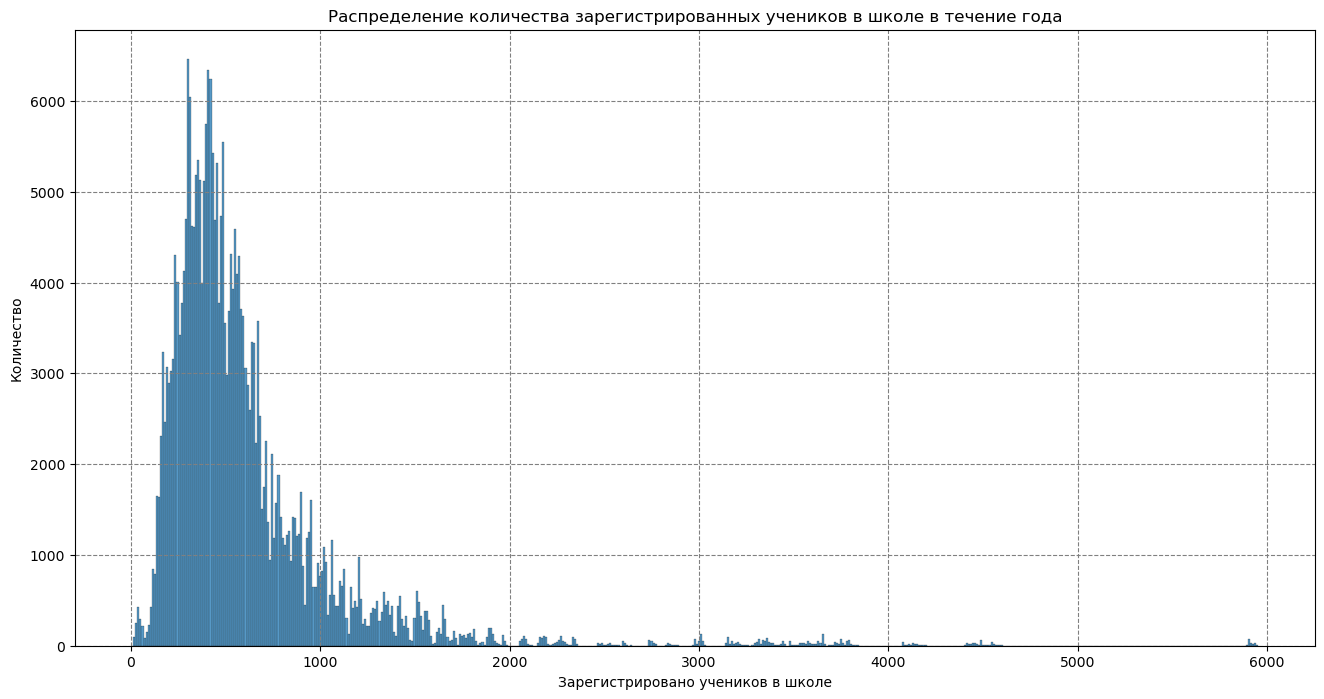

In [7]:
plt.subplots(figsize=(16, 8))

sns.histplot(data=df, x='Enrolled')

plt.grid(True, color='grey', linestyle='--')

plt.ylabel(ylabel='Количество')
plt.xlabel(xlabel='Зарегистрировано учеников в школе')
plt.title(label='Распределение количества зарегистрированных учеников в школе в течение года')

plt.show()

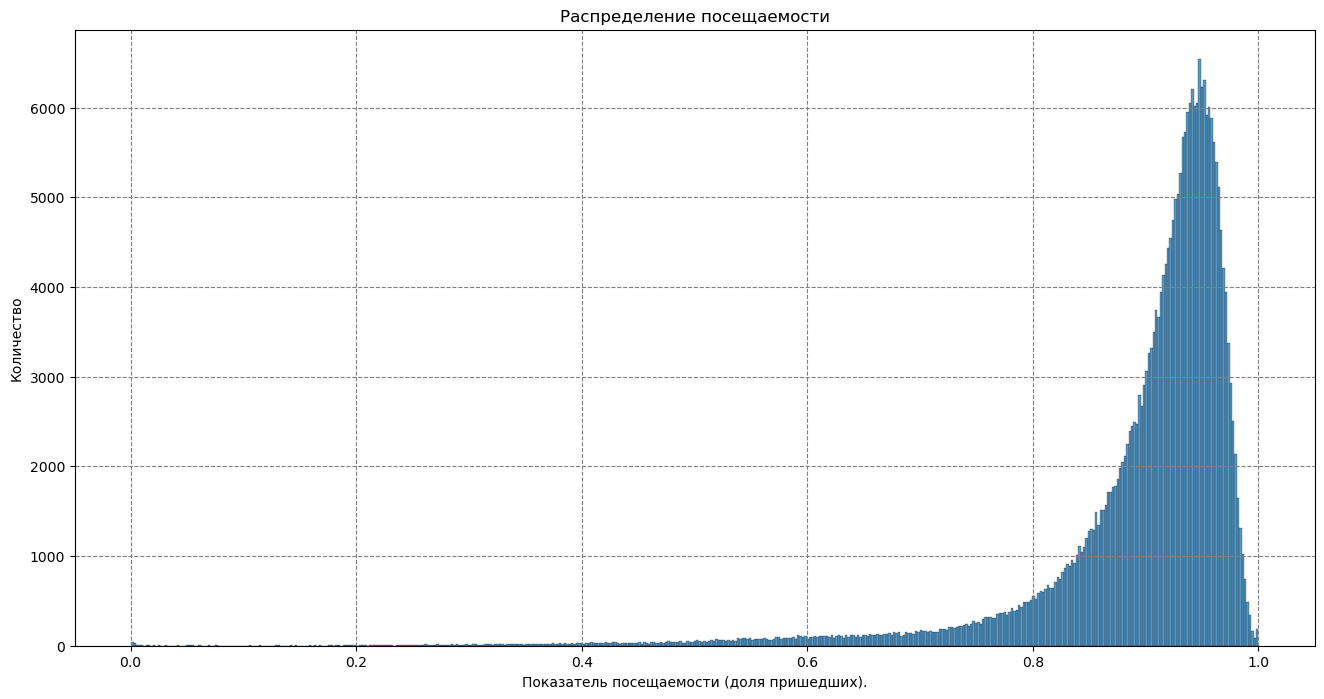

In [8]:
plt.subplots(figsize=(16, 8))

sns.histplot(data=df, x='Present_rate')

plt.grid(True, color='grey', linestyle='--')

plt.ylabel(ylabel='Количество')
plt.xlabel(xlabel='Показатель посещаемости (доля пришедших).')

plt.title(label='Распределение посещаемости')

plt.show()

Очистим методом межквартильного расстояния.

In [9]:
def clear_outliers(df: pd.DataFrame, columns: list[str], coeff: float = 1.5):
    df_clean = df.copy()

    medians = df_clean[columns].median()

    IQRs = df_clean[columns].quantile(.75) - df_clean[columns].quantile(.25)
    lowers = medians - coeff * IQRs
    uppers = medians + coeff * IQRs

    for id, column in enumerate(columns):
        df_clean = df_clean[(lowers[id] <= df_clean[column])
                            & (df_clean[column] <= uppers[id])]

    return df_clean

In [10]:
df = clear_outliers(df, ['Enrolled', 'Present_rate'], coeff=2)

/tmp/ipykernel_99115/2236086003.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_clean = df_clean[(lowers[id] <= df_clean[column])
/tmp/ipykernel_99115/2236086003.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  & (df_clean[column] <= uppers[id])]


Очистка выполнена с окном в 2 межквартальных расстояния вокруг медианы.

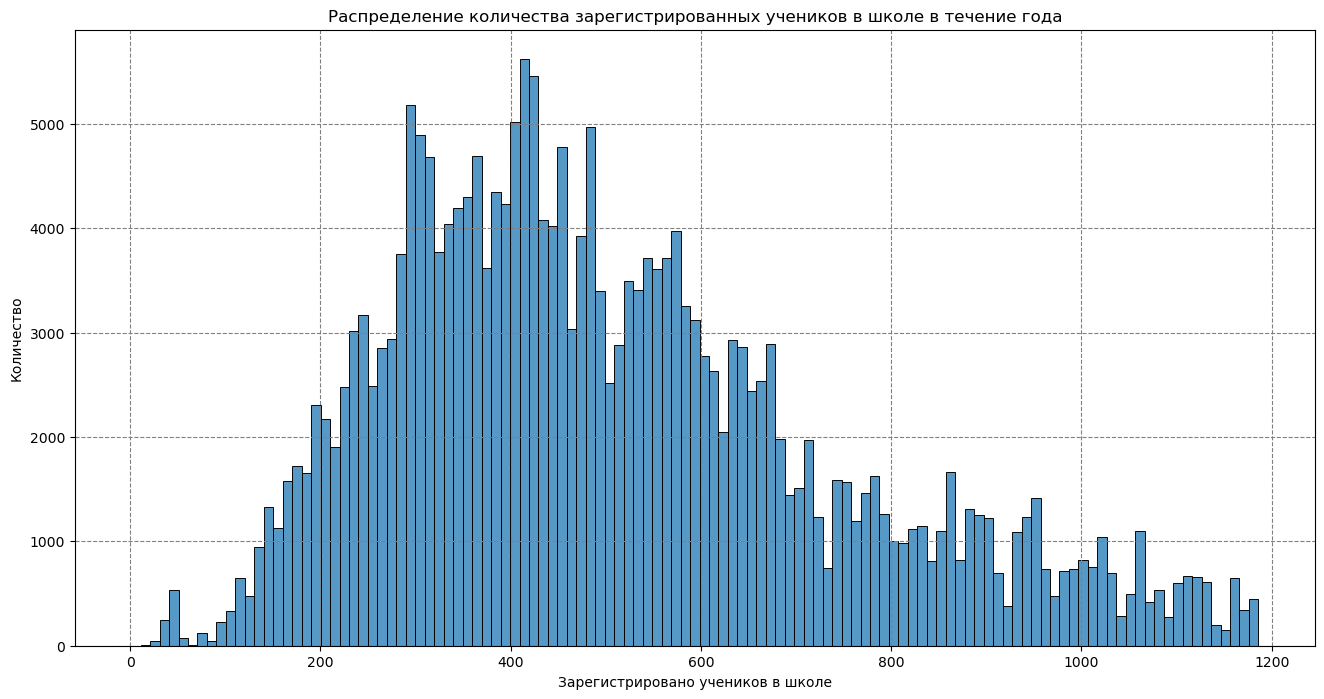

In [11]:
plt.subplots(figsize=(16, 8))

sns.histplot(data=df, x='Enrolled')
plt.ylabel(ylabel='Количество')
plt.xlabel(xlabel='Зарегистрировано учеников в школе')
plt.title(label='Распределение количества зарегистрированных учеников в школе в течение года')

plt.grid(True, color='grey', linestyle='--')

plt.show()

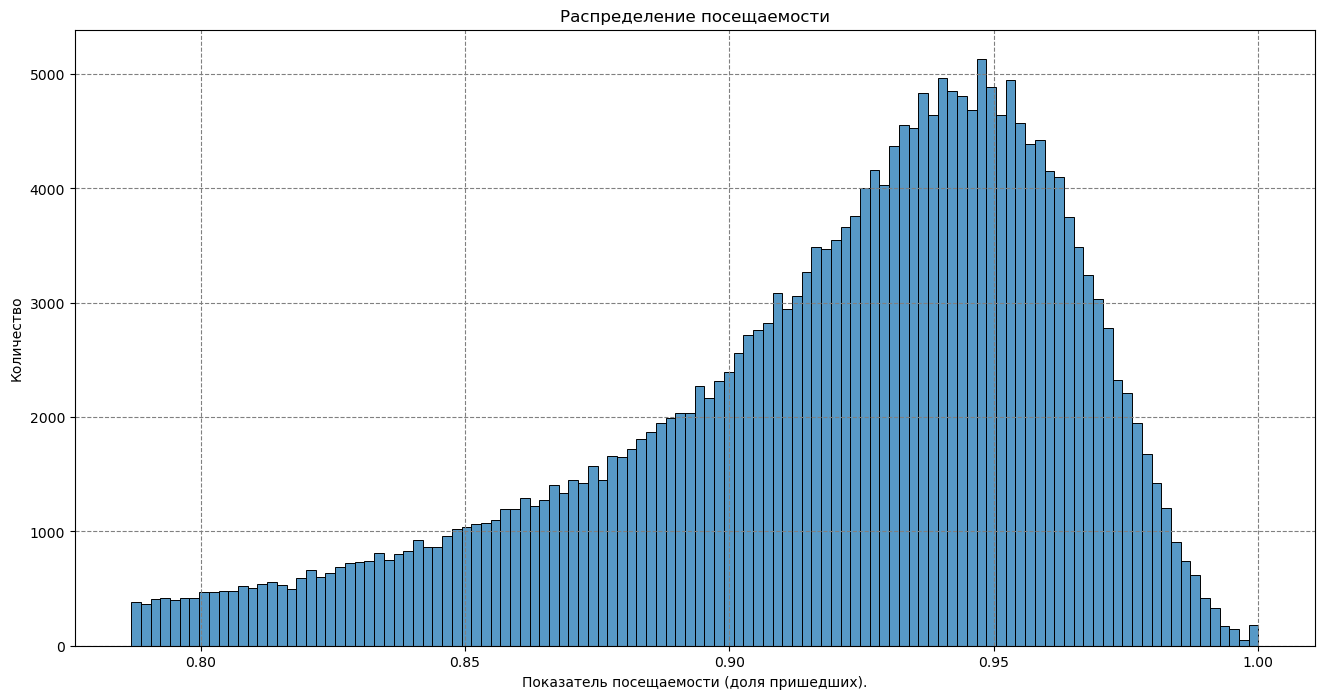

In [12]:
plt.subplots(figsize=(16, 8))

sns.histplot(data=df, x='Present_rate')
plt.ylabel(ylabel='Количество')
plt.xlabel(xlabel='Показатель посещаемости (доля пришедших).')
plt.title(label='Распределение посещаемости')

plt.grid(True, color='grey', linestyle='--')

plt.show()

### 2. Генерация фичей.

В части с анализом мы увидели, что посещаемость зависит от дня недели и сезона, поэтому добавим в таблицу столбцы с номером дня в году и номером дня в неделе. Кроме этого полезным может оказаться и район города, ограничимся только буквой в коде школы.

In [13]:
df['Day_of_year'] = df['Date'].dt.day_of_year
df['Day_of_week'] = df['Date'].dt.day_of_week
df['Borough'] = df['School DBN'].map(lambda x: x[2])


In [14]:
df[['Enrolled', 'Date']].groupby('Date').sum()

,Enrolled
Date,
2018-09-04,264
2018-09-05,644428
2018-09-06,671029
2018-09-07,668828
2018-09-12,701952
...,...
2019-06-20,483234
2019-06-21,396939
2019-06-24,366627


In [15]:
df_dropped = df.drop(columns=['Absent', 'Present', 'Date', 'School DBN'])

In [16]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233507 entries, 0 to 277144
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Enrolled      233507 non-null  int64  
 1   Released      233507 non-null  int64  
 2   Present_rate  233507 non-null  float64
 3   Day_of_year   233507 non-null  int32  
 4   Day_of_week   233507 non-null  int32  
 5   Borough       233507 non-null  object 
dtypes: float64(1), int32(2), int64(2), object(1)
memory usage: 10.7+ MB


In [17]:
df_dropped['Borough'].unique()

array(['M', 'X', 'Q', 'K', 'R'], dtype=object)

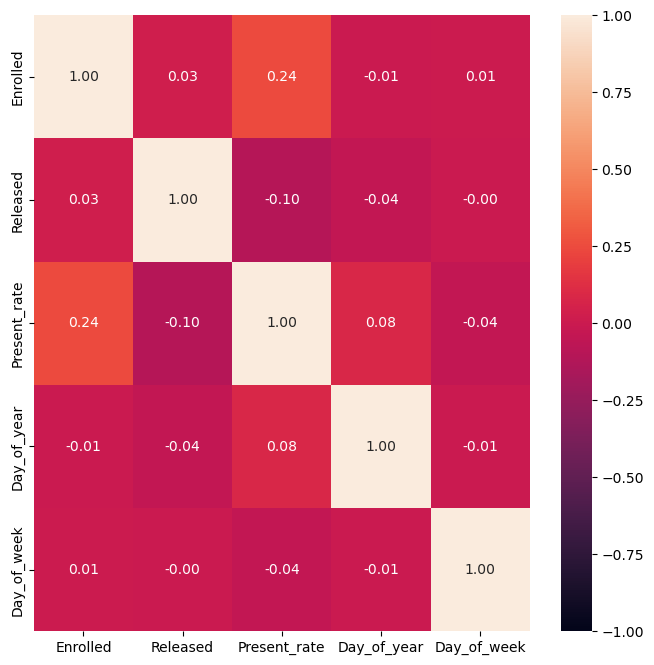

In [18]:
plt.subplots(figsize=(8, 8))

sns.heatmap(df_dropped.select_dtypes(exclude=['object']).corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, cbar='coolwarm')

plt.show()

In [19]:
df_dropped['Day_of_week_corrected'] = df_dropped['Day_of_week'].map(lambda x: (x-2)**2)

<Axes: >

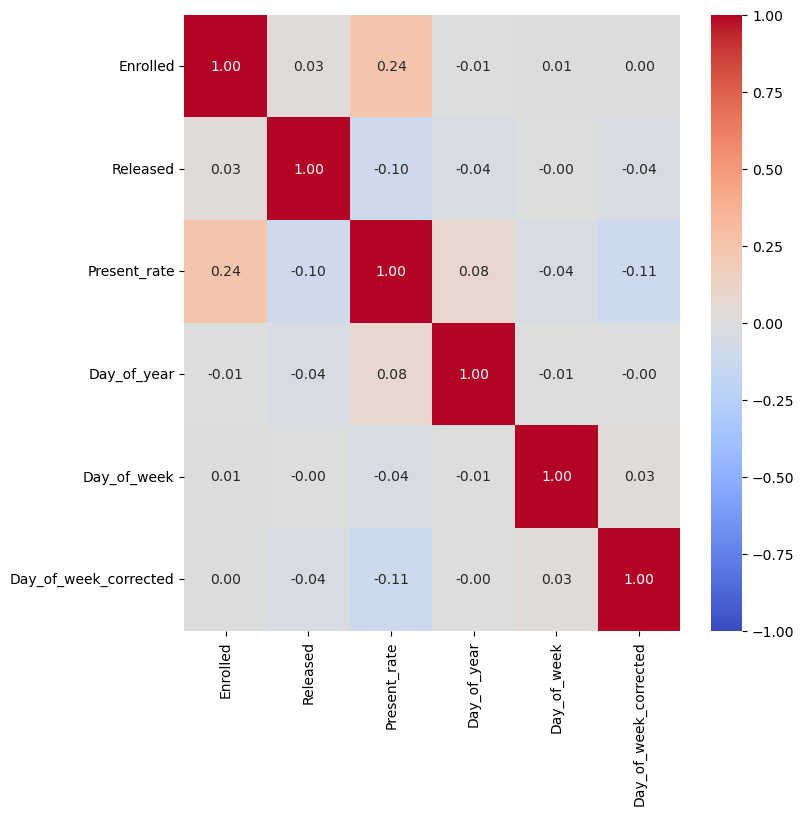

In [20]:
plt.subplots(figsize=(8, 8))

sns.heatmap(df_dropped.select_dtypes(exclude=['object']).corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')

Применим one hot encoding к признаку Borough

#### Сплит датафрейма, кодировка категориальных признаков и нормализация.

In [21]:
X = df_dropped.drop(columns=['Present_rate', 'Day_of_week'])
y = df_dropped['Present_rate']

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233507 entries, 0 to 277144
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Enrolled               233507 non-null  int64 
 1   Released               233507 non-null  int64 
 2   Day_of_year            233507 non-null  int32 
 3   Borough                233507 non-null  object
 4   Day_of_week_corrected  233507 non-null  int64 
dtypes: int32(1), int64(3), object(1)
memory usage: 9.8+ MB


In [23]:
numerical_features = X.select_dtypes(include=['int64', 'int32']).columns.values
categorical_features = ['Borough']

print(numerical_features)
print(categorical_features)

['Enrolled' 'Released' 'Day_of_year' 'Day_of_week_corrected']
['Borough']


In [24]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

In [25]:
# Кодировка и нормализация

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

In [26]:
X.head()

,Enrolled,Released,Day_of_year,Borough,Day_of_week_corrected
0,172,0,248,M,0
1,171,0,249,M,1
2,172,0,250,M,4
3,173,0,255,M,0
4,173,0,256,M,1


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37)

In [28]:
X_train.head()

,Enrolled,Released,Day_of_year,Borough,Day_of_week_corrected
57772,482,0,353,X,0
270878,301,0,128,M,0
158168,331,0,285,K,4
239478,403,0,119,Q,4
213302,312,0,59,Q,1


Данные подготовлены для использования в обучении алгоритмов.

### Случайный лес

Начннем с метода случайного леса

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from scipy.stats import randint

pipeline_rf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=37))
    ]
)

param_distributions_rf = {
    'regressor__n_estimators': randint(200, 500),
    'regressor__max_depth': randint(1, 20),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 20)
}

In [30]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error

Поиск подходящих гиперпараметров будем проводить с помощью grid_search с кросс-валидацией 3-fold.

In [31]:
random_search_rf = RandomizedSearchCV(estimator=pipeline_rf, param_distributions=param_distributions_rf,
                                      n_iter=20, cv=5, verbose=4, random_state=37, n_jobs=-1)

In [32]:
%%time
random_search_rf.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END regressor__max_depth=4, regressor__min_samples_leaf=4, regressor__min_samples_split=12, regressor__n_estimators=263;, score=0.146 total time=  57.5s
[CV 2/5] END regressor__max_depth=4, regressor__min_samples_leaf=4, regressor__min_samples_split=12, regressor__n_estimators=263;, score=0.132 total time= 1.0min
[CV 3/5] END regressor__max_depth=4, regressor__min_samples_leaf=4, regressor__min_samples_split=12, regressor__n_estimators=263;, score=0.140 total time= 1.0min
[CV 4/5] END regressor__max_depth=4, regressor__min_samples_leaf=4, regressor__min_samples_split=12, regressor__n_estimators=263;, score=0.130 total time=  58.3s
[CV 5/5] END regressor__max_depth=4, regressor__min_samples_leaf=4, regressor__min_samples_split=12, regressor__n_estimators=263;, score=0.145 total time=  59.1s
[CV 1/5] END regressor__max_depth=9, regressor__min_samples_leaf=9, regressor__min_samples_split=5, regressor__n_estimators=246;

/home/anatolii/Soft/miniforge3/envs/school-student-daily-attendance-env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END regressor__max_depth=18, regressor__min_samples_leaf=2, regressor__min_samples_split=9, regressor__n_estimators=424;, score=0.357 total time= 3.8min
[CV 4/5] END regressor__max_depth=18, regressor__min_samples_leaf=2, regressor__min_samples_split=9, regressor__n_estimators=424;, score=0.349 total time= 3.8min
[CV 5/5] END regressor__max_depth=18, regressor__min_samples_leaf=2, regressor__min_samples_split=9, regressor__n_estimators=424;, score=0.353 total time= 3.7min
[CV 1/5] END regressor__max_depth=19, regressor__min_samples_leaf=12, regressor__min_samples_split=3, regressor__n_estimators=499;, score=0.339 total time= 4.2min
[CV 1/5] END regressor__max_depth=12, regressor__min_samples_leaf=17, regressor__min_samples_split=13, regressor__n_estimators=319;, score=0.279 total time= 2.3min
[CV 3/5] END regressor__max_depth=19, regressor__min_samples_leaf=12, regressor__min_samples_split=3, regressor__n_estimators=499;, score=0.340 total time= 4.1min
[CV 2/5] END regressor__

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               array(['Enrolled', 'Released', 'Day_of_year', 'Day_of_week_corrected'],
      dtype=object)),
                                                                              ('cat',
                                                                               OneHotEncoder(),
                                                                               ['Borough'])])),
                                             ('regressor',
                                              RandomForestRegressor(random_state=37))]),
                   n_iter=20, n_jobs=-1,
                   param_d...440>,
                                        'regressor__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f76b1ca2120>,
                                        'regressor__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f76b35259d0>,
                                        'regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f76b29eee40>},
                   random_state=37, verbose=4)

In [33]:
y_pred = random_search_rf.best_estimator_.predict(X=X_test)

mae_rf = mean_absolute_error(y_true=y_test, y_pred=y_pred)
mse_rf = mean_squared_error(y_true=y_test, y_pred=y_pred)

print(f'MAE: {mae_rf}, MSE: {mse_rf}.')

MAE: 0.026505744342199114, MSE: 0.0012354725134822789.


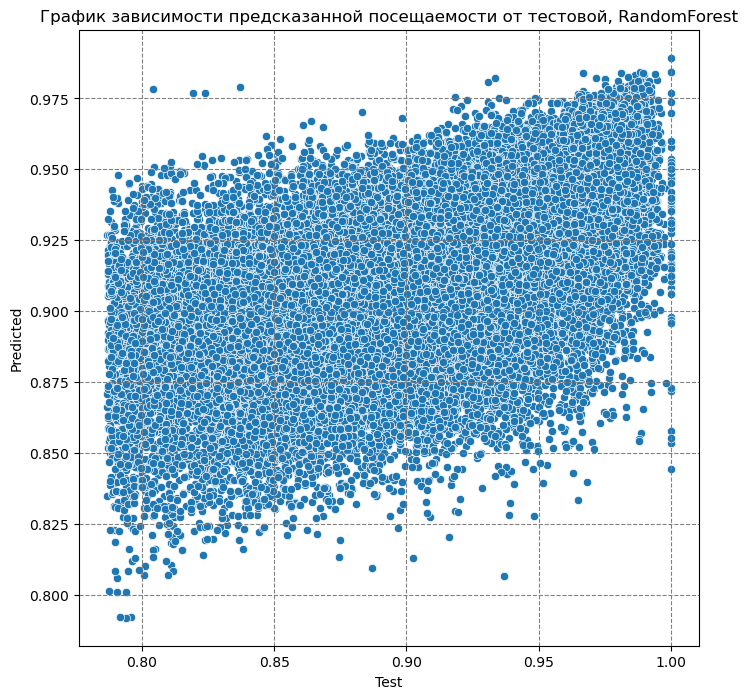

In [34]:
plt.subplots(figsize=(8, 8))

sns.scatterplot(data=pd.DataFrame(data={'Test': y_test, 'Predicted': y_pred}), x='Test', y='Predicted')

plt.grid(True, color='grey', linestyle='--')
plt.title('График зависимости предсказанной посещаемости от тестовой, RandomForest')

plt.show()

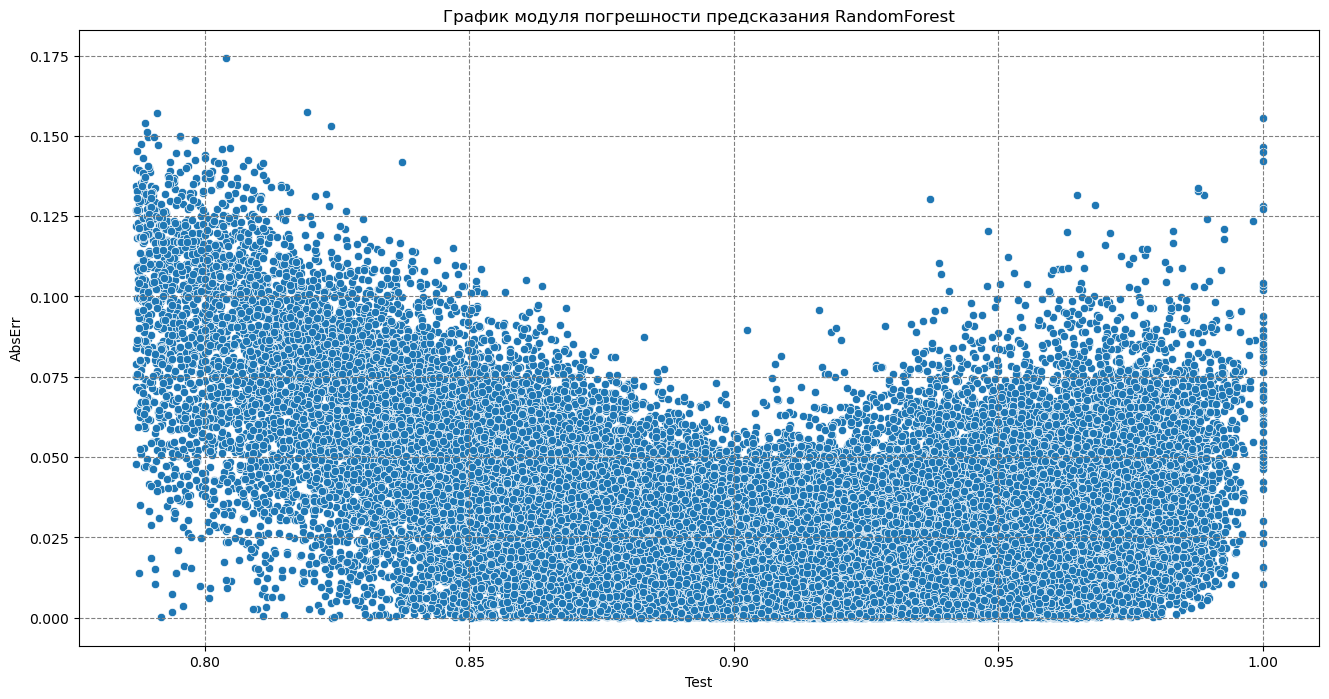

In [35]:
plt.subplots(figsize=(16, 8))

sns.scatterplot(data=pd.DataFrame(data={'Test': y_test, 'AbsErr': abs(y_test - y_pred)}), x='Test', y='AbsErr')

plt.grid(True, color='grey', linestyle='--')

plt.title('График модуля погрешности предсказания RandomForest')
plt.show()

In [36]:
random_search_rf.best_params_

{'regressor__max_depth': 18,
 'regressor__min_samples_leaf': 2,
 'regressor__min_samples_split': 9,
 'regressor__n_estimators': 424}

Модель случайного леса хорошо аппроксимирует относительную посещаемость.

Лучшая модель получилась с 424 деревьями глубиной <=18 слоев. В среднем (средняя абсолютная ошибка) модель ошибается на ~2.5%.
Лучше всего модель предсказывает посещаемость в области 90%.

### XGBoost


In [37]:
import xgboost as xgb
from scipy.stats import uniform

In [38]:
import numpy as np

params_xgbr = {
    'model__n_estimators': list(range(100, 300+1, 50)),
    'model__max_depth': list(range(8, 20+1, 2)),
    'model__subsample':  list(np.linspace(0.5, 1.0, 6))
}

xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRFRegressor(random_state=37))
])

In [39]:
grid_search_xgbr = RandomizedSearchCV(estimator=xgboost_pipeline, param_distributions=params_xgbr, n_iter=20, cv=5, n_jobs=-1, verbose=4)

In [40]:
%%time
grid_search_xgbr.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END model__max_depth=16, model__n_estimators=200, model__subsample=0.9;, score=0.313 total time= 1.2min


/home/anatolii/Soft/miniforge3/envs/school-student-daily-attendance-env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END model__max_depth=16, model__n_estimators=200, model__subsample=0.9;, score=0.311 total time= 1.3min
[CV 2/5] END model__max_depth=16, model__n_estimators=200, model__subsample=0.9;, score=0.302 total time= 1.3min
[CV 5/5] END model__max_depth=16, model__n_estimators=200, model__subsample=0.9;, score=0.308 total time= 1.3min
[CV 4/5] END model__max_depth=16, model__n_estimators=200, model__subsample=0.9;, score=0.303 total time= 1.3min
[CV 3/5] END model__max_depth=20, model__n_estimators=150, model__subsample=0.9;, score=0.288 total time= 2.3min
[CV 2/5] END model__max_depth=20, model__n_estimators=150, model__subsample=0.9;, score=0.281 total time= 2.4min
[CV 1/5] END model__max_depth=20, model__n_estimators=150, model__subsample=0.9;, score=0.295 total time= 2.4min
[CV 1/5] END model__max_depth=18, model__n_estimators=200, model__subsample=0.9;, score=0.311 total time= 2.1min
[CV 3/5] END model__max_depth=18, model__n_estimators=200, model__subsample=0.9;, score=0.306 to

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               array(['Enrolled', 'Released', 'Day_of_year', 'Day_of_week_corrected'],
      dtype=object)),
                                                                              ('cat',
                                                                               OneHotEncoder(),
                                                                               ['Borough'])])),
                                             ('model',
                                              XGBRFRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_byle...
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             objective='reg:squarederror',
                                                             random_state=37,
                                                             reg_alpha=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__max_depth': [8, 10, 12, 14, 16,
                                                             18, 20],
                                        'model__n_estimators': [100, 150, 200,
                                                                250, 300],
                                        'model__subsample': [np.float64(0.5),
                                                             np.float64(0.6),
                                                             np.float64(0.7),
                                                             np.float64(0.8),
                                                             np.float64(0.9),
                                                             np.float64(1.0)]},
                   verbose=4)

In [41]:
grid_search_xgbr.best_params_

{'model__subsample': np.float64(0.5),
 'model__n_estimators': 300,
 'model__max_depth': 18}

In [42]:
y_pred_xgb = grid_search_xgbr.best_estimator_.predict(X=X_test)

mae_xgb = mean_absolute_error(y_true=y_test, y_pred=y_pred_xgb)
mse_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred_xgb)

print(f'MAE: {mae_xgb}, MSE: {mse_xgb}.')

MAE: 0.02725957381679611, MSE: 0.0012930409016808362.


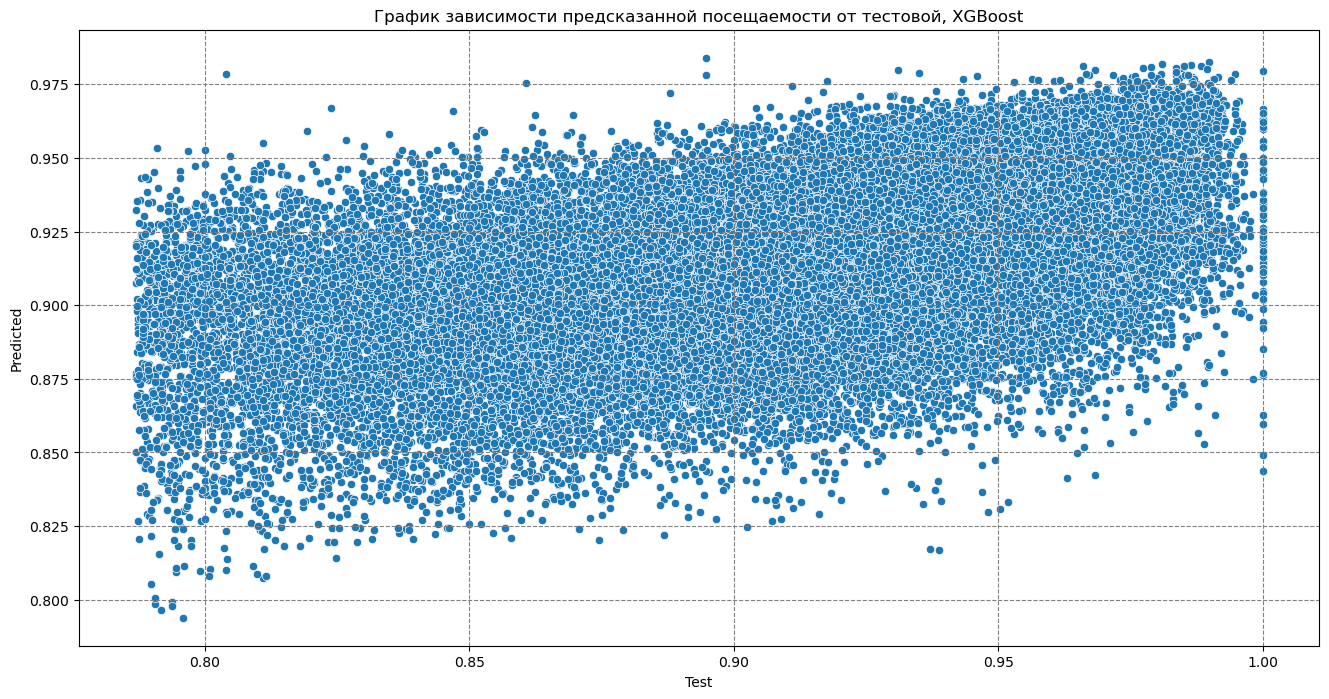

In [43]:
plt.subplots(figsize=(16, 8))

sns.scatterplot(data=pd.DataFrame(data={'Test': y_test, 'Predicted': y_pred_xgb}), x='Test', y='Predicted')

plt.grid(True, color='grey', linestyle='--')

plt.title('График зависимости предсказанной посещаемости от тестовой, XGBoost')
plt.show()

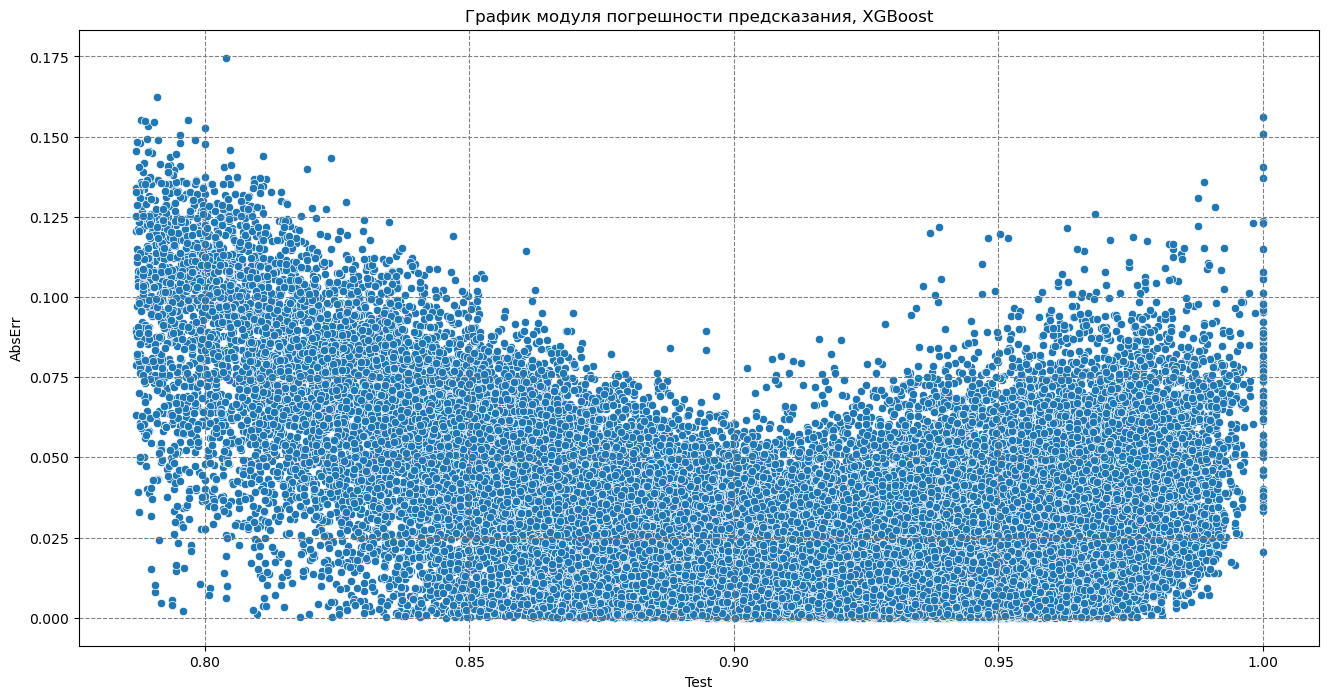

In [44]:
plt.subplots(figsize=(16, 8))

sns.scatterplot(data=pd.DataFrame(data={'Test': y_test, 'AbsErr': abs(y_test - y_pred_xgb)}), x='Test', y='AbsErr')

plt.grid(True, color='grey', linestyle='--')

plt.title('График модуля погрешности предсказания, XGBoost')
plt.show()

Результаты работы модели XGBoost очень похожи на результаты работы модели RandomForest. Область лучшей предсказательной способности ледит в окрестности 90% и в среднем модель ошибается на 2,7% (средняя абсолютная ошибка).
Модель случайного леса оказалась немного лучше на тестовой выборке.

Обе модели начинают сильно ошибаться в областях с низкой и высокой посещаемостью (около 80-85% и 95-100%)